In [1]:
Output = ('/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1011. Emission Mixtures/P1011.3. Analyses/P1011.3.2. Biomarker Cluster Analysis/Output')
cur_date = "091023"

library(readxl)
library(tidyverse)
library(reshape2)
library(factoextra)
library(cowplot)

# reading in files
cytokine_df = data.frame(read_excel("Input/Processed_Cytokine_Data_081723.xlsx"))
mRNA_df = data.frame(read_excel("Input/Processed_mRNA_Data_081723.xlsx"))
# nemenyis_df = data.frame(read_excel("Input/Nemenyis_Results_100323.xlsx"))

# making some cols numeric
cytokine_df$Condensate_Conc = as.numeric(cytokine_df$Condensate_Conc)
mRNA_df$Concentration = as.numeric(mRNA_df$Concentration)
mRNA_df$Time_Point = as.numeric(mRNA_df$Time_Point)
# nemenyis_df$Time.Point = as.numeric(nemenyis_df$Time.Point)
# nemenyis_df$P.Value = as.numeric(nemenyis_df$P.Value)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa


Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp


Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


In [2]:
head(mRNA_df)
head(cytokine_df)
#head(nemenyis_df)

,Subject_No,Subject_ID,mRNA,Condensate,Burn_Condition,Concentration,Time_Point,Norm_ddCT
,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,6,M_6,HMOX1,PBS,PBS,NA,24,3.912311
2,5,F_5,HMOX1,PBS,PBS,NA,4,3.067190
3,1,F_1,HMOX1,PBS,PBS,NA,4,3.843045
4,2,M_2,HMOX1,PBS,PBS,NA,4,3.415457
5,3,M_3,HMOX1,PBS,PBS,NA,4,3.234524
6,4,F_4,HMOX1,PBS,PBS,NA,4,3.294681


,Subject_ID,Subject_No,Cytokine,Condensate,Burn_Condition,Condensate_Conc,Norm_Cytokine_Conc
,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,F_1,1,Eotaxin3,C,F,1,5.438924
2,F_1,1,Eotaxin3,C,F,25,3.630025
3,F_1,1,Eotaxin3,C,F,5,4.694272
4,F_1,1,Eotaxin3,C,S,1,6.165522
5,F_1,1,Eotaxin3,C,S,25,3.703871
6,F_1,1,Eotaxin3,C,S,5,4.562595


This analysis will use PCA to explore if there are clusters of biomarkers based on the condensate or burn condition. First will identify the biomarkers that are significant (p value < 0.1).

In [3]:
# sig_mRNA_df = nemenyis_df %>%
#     filter(Biomarker == "mRNA", P.Value < 0.1)
# sig_mRNAs = unique(sig_mRNA_df$Variable.Name)

# sig_cytokine_df = nemenyis_df %>%
#     filter(Biomarker == "Cytokine", P.Value < 0.1)
# sig_cytokines = unique(sig_cytokine_df$Variable.Name)

In [4]:
# finding number of unique biomarkers
# length(sig_mRNAs)
# length(sig_cytokines)

[1] 19

[1] 7

In [6]:
# creating 1 df and casting wide
wider_mRNA_df = mRNA_df %>%
    # creating a column that denotes the biomarker
    mutate(Biomarker = "mRNA") %>%
    # removing the subject no since that messes up pivoting
    select(-Subject_No) %>%
    # creating sample ids
    unite("SampleID", c(colnames(mRNA_df)[c(3:7)]), remove = FALSE) %>%
    pivot_wider(names_from = "Subject_ID", values_from = "Norm_ddCT") %>%
    # keeping sig mRNAs only, 24 hr time point, removing concentration of 5
    filter(#mRNA %in% sig_mRNAs, 
           Time_Point %in% c(4,24), Concentration %in% c(1,25,NA)) %>%
    column_to_rownames(var = "SampleID") 

wider_cytokine_df = cytokine_df %>%
    # creating a column that denotes the biomarker
    mutate(Biomarker = "Cytokine") %>%
    # removing the subject no since that messes up pivoting
    select(-Subject_No) %>%
    # creating sample ids
    unite("SampleID", c(colnames(cytokine_df)[c(3:6)]), remove = FALSE) %>%
    pivot_wider(names_from = "Subject_ID", values_from = "Norm_Cytokine_Conc") %>%
    # keeping sig mRNAs only, removing concentration of 5
    filter(#Cytokine %in% sig_cytokines, 
           Condensate_Conc %in% c(1,25,NA)) %>%
    column_to_rownames(var = "SampleID") 

head(wider_mRNA_df)
head(wider_cytokine_df)

,mRNA,Condensate,Burn_Condition,Concentration,Time_Point,Biomarker,M_6,F_5,F_1,M_2,M_3,F_4
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
HMOX1_PBS_PBS_NA_24,HMOX1,PBS,PBS,NA,24,mRNA,3.912311,-14.276188,-14.4683669,-14.2478117,-14.4096419,-13.94705692
HMOX1_PBS_PBS_NA_4,HMOX1,PBS,PBS,NA,4,mRNA,3.820872,3.067190,3.8430445,3.4154567,3.2345242,3.29468128
HMOX1_C_F_25_4,HMOX1,C,F,25,4,mRNA,-10.072194,-1.365144,-16.2508970,2.4192352,1.6632660,1.17018046
HMOX1_C_S_25_4,HMOX1,C,S,25,4,mRNA,-16.998608,1.798422,0.7883619,-1.1610217,0.1780591,1.29378688
HMOX1_P_F_25_4,HMOX1,P,F,25,4,mRNA,2.464774,-16.941843,2.0417508,0.9382362,-0.7053270,0.07733123
HMOX1_P_S_25_4,HMOX1,P,S,25,4,mRNA,-14.786717,-15.002740,-18.4750119,-15.6629303,-3.8789395,-17.61538360


,Cytokine,Condensate,Burn_Condition,Condensate_Conc,Biomarker,F_1,M_2,M_3,F_4,F_5,M_6
,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Eotaxin3_C_F_1,Eotaxin3,C,F,1,Cytokine,5.438924,3.947832,4.008353,1.844484,2.482925,2.2775315
Eotaxin3_C_F_25,Eotaxin3,C,F,25,Cytokine,3.630025,4.340598,3.506399,2.337052,1.618586,-1.9936786
Eotaxin3_C_S_1,Eotaxin3,C,S,1,Cytokine,6.165522,4.577171,4.069405,2.691837,1.330184,2.7385222
Eotaxin3_C_S_25,Eotaxin3,C,S,25,Cytokine,3.703871,4.272783,2.546582,1.805488,2.116017,1.5451229
Eotaxin3_P_F_1,Eotaxin3,P,F,1,Cytokine,3.995355,3.519360,4.361608,1.296307,2.432985,0.9605363
Eotaxin3_P_F_25,Eotaxin3,P,F,25,Cytokine,2.263359,3.026700,4.033679,2.680696,2.931078,1.7257527


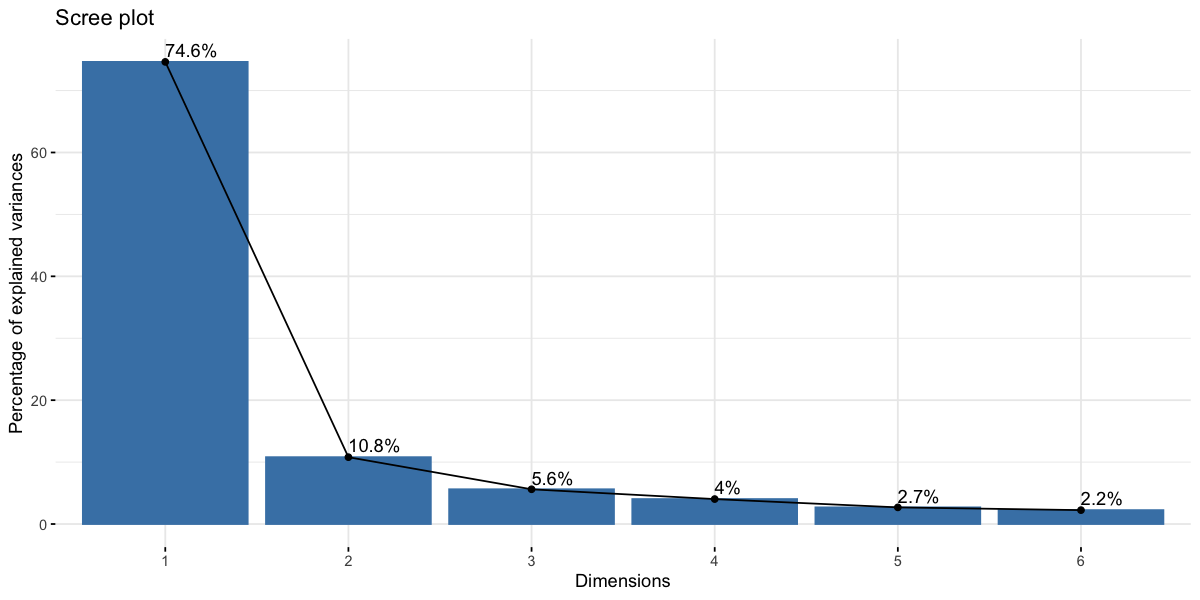

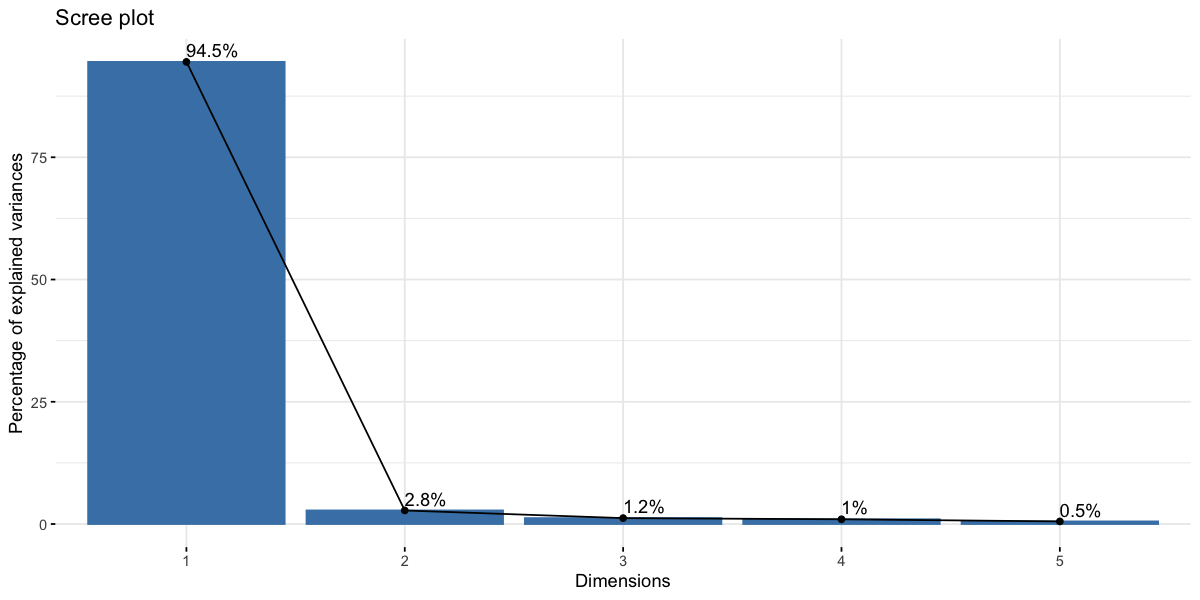

In [7]:
# running pca 
mRNA_pca = prcomp(wider_mRNA_df[,7:12], center = TRUE)
cytokine_pca = prcomp(wider_cytokine_df[,7:11], center = TRUE)

# looking a scree plot to see how much of the variance was captured in the first 2 eigenvectors
options(repr.plot.width = 10, repr.plot.height = 5) #changing size
fviz_eig(mRNA_pca, addlabels = TRUE)
fviz_eig(cytokine_pca, addlabels = TRUE)

The standard way to detect outliers in genetics is the criterion of being “more than 6 standard deviations away from the mean”. [source](https://privefl.github.io/blog/detecting-outlier-samples-in-pca/)

In [8]:
outlier_detection = function(pca_df){
    # """
    # Creating a scoring function for to detect PCA sample outliers. 
    # :param (input): PCA df (df)
    # :output: outlier names
    # """
    
    # getting scores
    scores = pca_df$x
    # identifying samples that are > 6 standard deviations away from the mean
    outlier_indices = apply(scores, 2, function(x) which( abs(x - mean(x)) > (6 * sd(x)) )) %>%
        Reduce(union, .)
    # getting sample names
    outliers = rownames(scores)[outlier_indices]
    
    return(outliers)
}

# calling fn
mRNA_outliers = outlier_detection(mRNA_pca)  
cytokine_outliers = outlier_detection(cytokine_pca)  

In [9]:
# getting length
length(mRNA_outliers)
length(cytokine_outliers)

[1] 0

[1] 1

There were no outliers, so the next chunk of code isn't necessary.

In [9]:
# # going back to remove outliers
# `%notin%` <- Negate(`%in%`)
# no_outliers_FC_mRNA_df = wider_FC_mRNA_df[row.names(wider_FC_mRNA_df)%notin% mRNA_outliers,]
# no_outliers_FC_cytokine_df = wider_FC_cytokine_df[row.names(wider_FC_cytokine_df)%notin% cytokine_outliers,]

# # rerunning pca 
# no_outliers_mRNA_pca = prcomp(no_outliers_FC_mRNA_df[,7:12], center = TRUE)
# no_outliers_cytokine_pca = prcomp(no_outliers_FC_cytokine_df[,7:11], center = TRUE)

# # looking a scree plot to see how much of the variance was captured in first 2 eigenvectors
# options(repr.plot.width = 10, repr.plot.height = 5) #changing size
# fviz_eig(no_outliers_mRNA_pca, addlabels = TRUE)
# fviz_eig(no_outliers_cytokine_pca, addlabels = TRUE)

In [12]:
# creating 1 df with eigenvectors, normalized values, condensate, burn condition data
mRNA_pca_df = data.frame(mRNA_pca$x[,1:2]) %>%
               rownames_to_column(var = "Sample_ID") 
cytokine_pca_df = data.frame(cytokine_pca$x[,1:2]) %>%
               rownames_to_column(var = "Sample_ID") 

more_data_biomarker_df = full_join(wider_mRNA_df[,1:6] %>% 
                                    rename(Biomarker_Name = mRNA) %>%
                                    rownames_to_column(var = "Sample_ID"), 
                                wider_cytokine_df[,1:5] %>% 
                                    rename(Biomarker_Name = Cytokine, Concentration = Condensate_Conc) %>%
                                    mutate(Time_Point = 24) %>%
                                    rownames_to_column(var = "Sample_ID")) 

full_eigenvector_df = inner_join(rbind(mRNA_pca_df, cytokine_pca_df), 
                                             more_data_biomarker_df) %>%
    column_to_rownames(var = "Sample_ID")
    
head(full_eigenvector_df)

Joining with `by = join_by(Sample_ID, Biomarker_Name, Condensate,
Burn_Condition, Concentration, Time_Point, Biomarker)`
Joining with `by = join_by(Sample_ID)`


,PC1,PC2,Biomarker_Name,Condensate,Burn_Condition,Concentration,Time_Point,Biomarker
,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
HMOX1_PBS_PBS_NA_24,15.246713,-9.8479368,HMOX1,PBS,PBS,NA,24,mRNA
HMOX1_PBS_PBS_NA_4,-22.741233,-0.8211437,HMOX1,PBS,PBS,NA,4,mRNA
HMOX1_C_F_25_4,-6.066659,3.8282006,HMOX1,C,F,25,4,mRNA
HMOX1_C_S_25_4,-11.218466,14.2608254,HMOX1,C,S,25,4,mRNA
HMOX1_P_F_25_4,-8.655020,-4.0106239,HMOX1,P,F,25,4,mRNA
HMOX1_P_S_25_4,19.607556,-1.0631509,HMOX1,P,S,25,4,mRNA


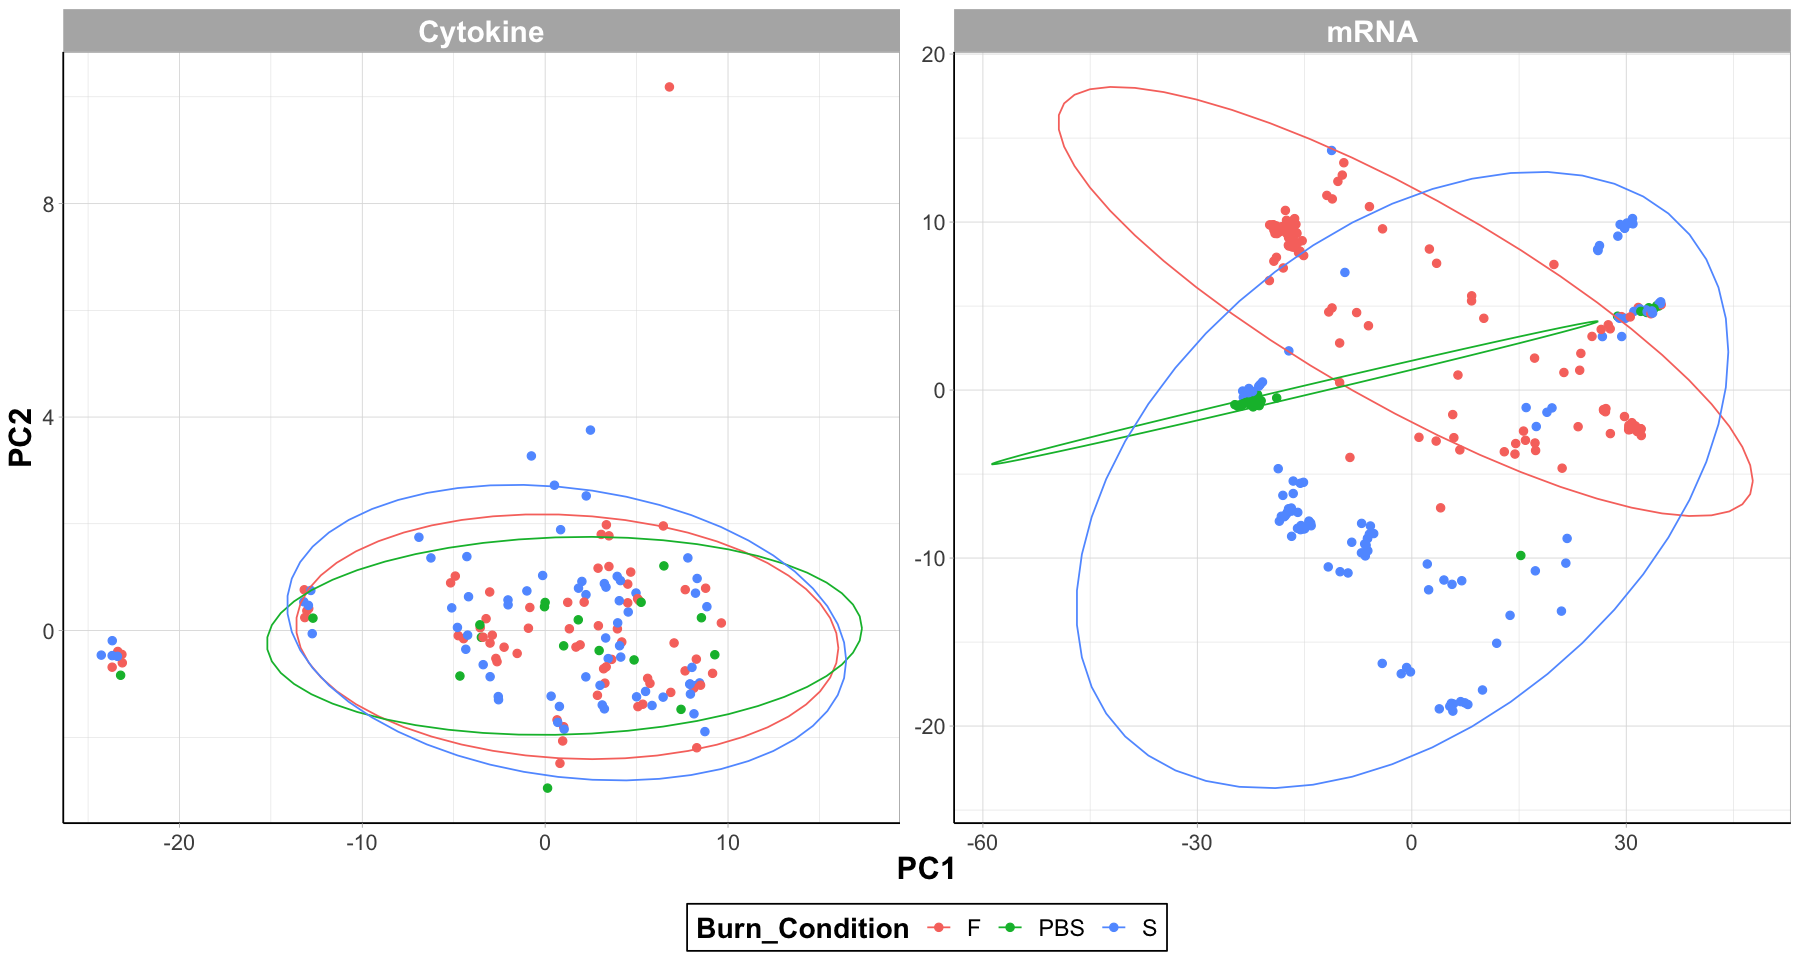

In [13]:
options(repr.plot.width=15, repr.plot.height=8) #changing size
ggplot(data = full_eigenvector_df, aes(x = PC1, y = PC2, color = Burn_Condition)) + 
  geom_point(size = 2) + 
  stat_ellipse(level = 0.95) + # 95% confidence ellipses

  facet_wrap(~Biomarker, scales = "free") + 

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 17), #changes legend title
        legend.text = element_text(size = 14), #changes legend text
        legend.position = 'bottom',
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) #+ #changes size of facet y axis 
  #xlab('Dimension 1 (67.5%)') + ylab('Dimension 2 (9.5%)')  #changing axis labels 

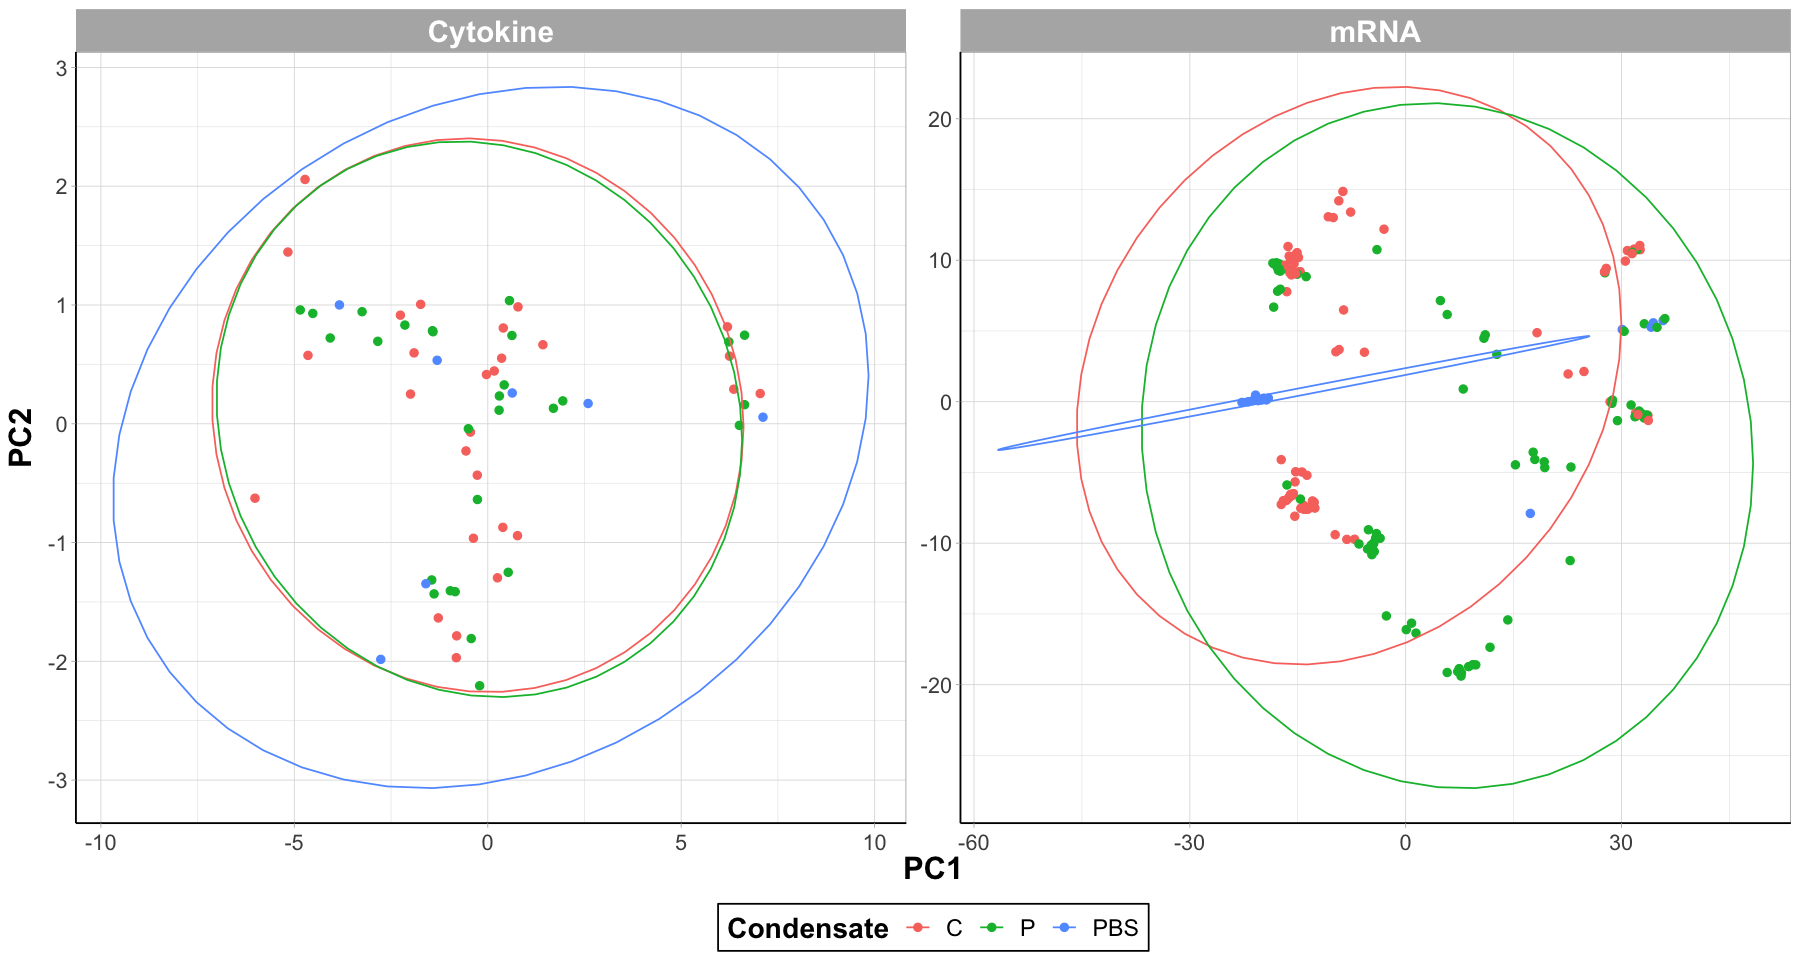

In [12]:
ggplot(data = full_eigenvector_df, aes(x = PC1, y = PC2, color = Condensate)) + 
  geom_point(size = 2) + 
  stat_ellipse(level = 0.95) + # 95% confidence ellipses

  facet_wrap(~Biomarker, scales = "free") + 

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 17), #changes legend title
        legend.text = element_text(size = 14), #changes legend text
        legend.position = 'bottom',
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) #+ #changes size of facet y axis 
  #xlab('Dimension 1 (67.5%)') + ylab('Dimension 2 (9.5%)')  #changing axis labels 

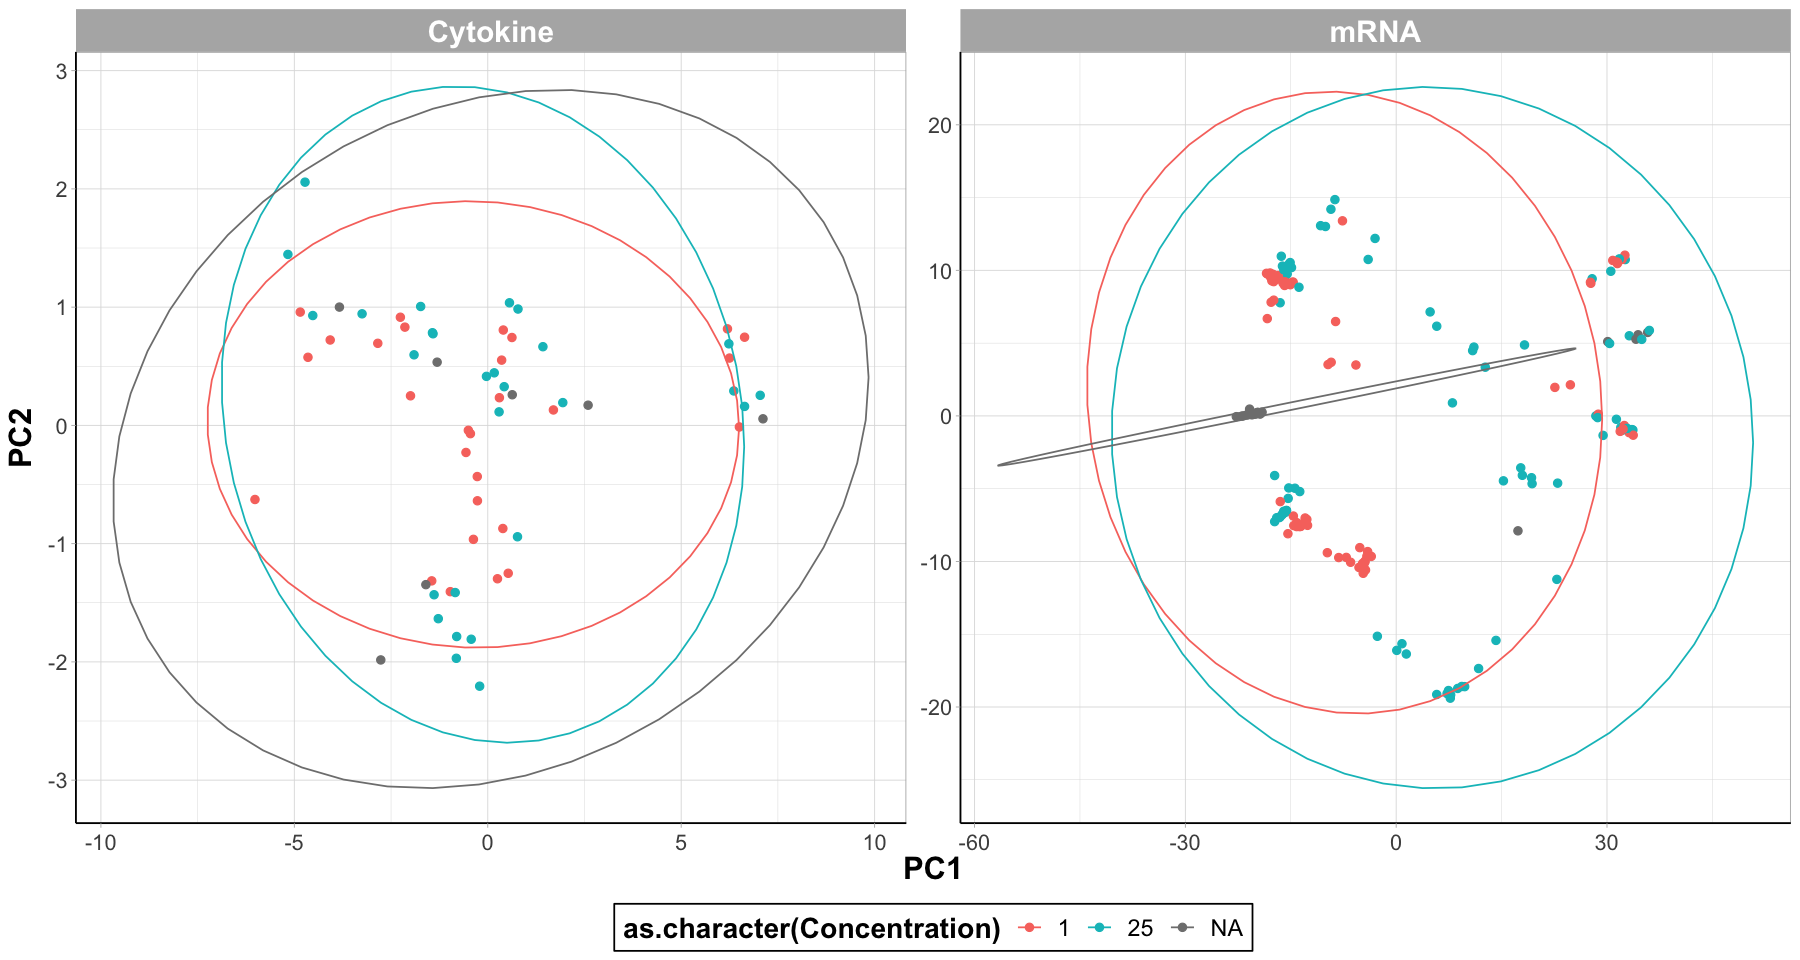

In [13]:
ggplot(data = full_eigenvector_df, aes(x = PC1, y = PC2, color = as.character(Concentration))) + 
  geom_point(size = 2) + 
  stat_ellipse(level = 0.95) + # 95% confidence ellipses

  facet_wrap(~Biomarker, scales = "free") + 

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 17), #changes legend title
        legend.text = element_text(size = 14), #changes legend text
        legend.position = 'bottom',
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) #+ #changes size of facet y axis 
  #xlab('Dimension 1 (67.5%)') + ylab('Dimension 2 (9.5%)')  #changing axis labels 